## ANÁLISE EXPLORATORIA DOS DADOS

<h1 style="font-size:30px;"> Reconhecimento Visual de Tipos de Plástico</h1>

<h2> Classificação dos tipos de plástico</h2>

<h3>Origem dos dados:</h3>


Os dados estão integralmente disponíveis no Kaggle através <a href="https://www.kaggle.com/datasets/remnazkarart/plastic-classification-dataset">deste link</a>


## Índice
* [1 Carregue o conjunto de dados Plastic Classification](#1-Carregue-o-conjunto-de-dados-plastic-types)
* [2 Pré-processamento de conjuntos de dados](#2-Pré-processamento-de-conjuntos-de-dados)
* [3 Arquitetura do Modelo](#3-Arquitetura-do-Modelo)
* [4 Implementação do Modelo](#4-Implementação-do-Modelo)
* [5 Avaliação do Modelo](#5-Avaliação-do-Modelo)
* [6 Conclusão](#6-Conclusão)

# 0 Importação e Instalação das Bibliotecas

## 0.1 Instalação das bibliotecas

In [1]:
#!pip install opendatasets
#!pip install pandas
#!pip install imagehash
#!pip install tensorflow

## 0.2 Importação das bibliotecas

In [2]:
import numpy as np
import pandas as pd
import os
import random

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib
import seaborn as sns
from PIL import Image
import imagehash
from collections import defaultdict

In [4]:
import cv2

In [5]:
import tensorflow
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img,
)

from PIL import Image, UnidentifiedImageError


tensorflow.__version__

'2.17.0'

In [6]:

from glob import glob
from pathlib import Path
import os
import shutil

In [7]:
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["image.cmap"] = "gray"

In [8]:
SEED_VALUE = 42

# Corrigir semente para tornar o treinamento determinístico.
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1 Exploração de conjuntos de dados

In [9]:
# carregar as imagens
dataset = r"../data/Plastic_Classification/"

In [10]:
pasta_test = os.path.join(dataset, "test")
pasta_train = os.path.join(dataset, "train")
pasta_validation = os.path.join(dataset, "validation")

## 1.1 - Numero de classes 

In [11]:
# determinar o numero de classes
numero_de_classes_test = len(os.listdir(pasta_test))
numero_de_classes_train = len(os.listdir(pasta_train))
numero_de_classes_validation = len(os.listdir(pasta_validation))

In [42]:
print(f"\n📁 Número de classes na Pasta test: ",numero_de_classes_test )
print(f"\n📁 Número de classes na Pasta train: ",numero_de_classes_train )
print(f"\n📁 Número de classes na Pasta validation: ",numero_de_classes_validation )


📁 Número de classes na Pasta test:  7

📁 Número de classes na Pasta train:  7

📁 Número de classes na Pasta validation:  7


## 1.2 Plotar algumas imagens para verificar a leitura do dataset

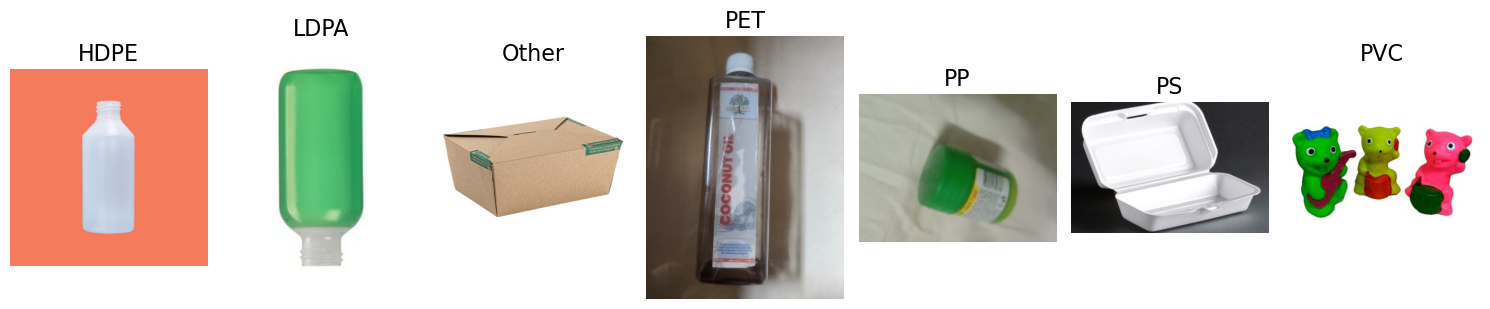

In [43]:
# Caminho das subpastas (cada uma é uma classe)
base_dir = '../data/Plastic_Classification/test/'
classes = os.listdir(base_dir)

# Mostrar 1 imagem aleatória por classe
plt.figure(figsize=(15, 6))

for i, plastic_class in enumerate(classes):
    class_path = os.path.join(base_dir, plastic_class)
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(1, 7, i+1)
    plt.imshow(img)
    plt.title(plastic_class)
    plt.axis('off')

plt.tight_layout()
plt.show()

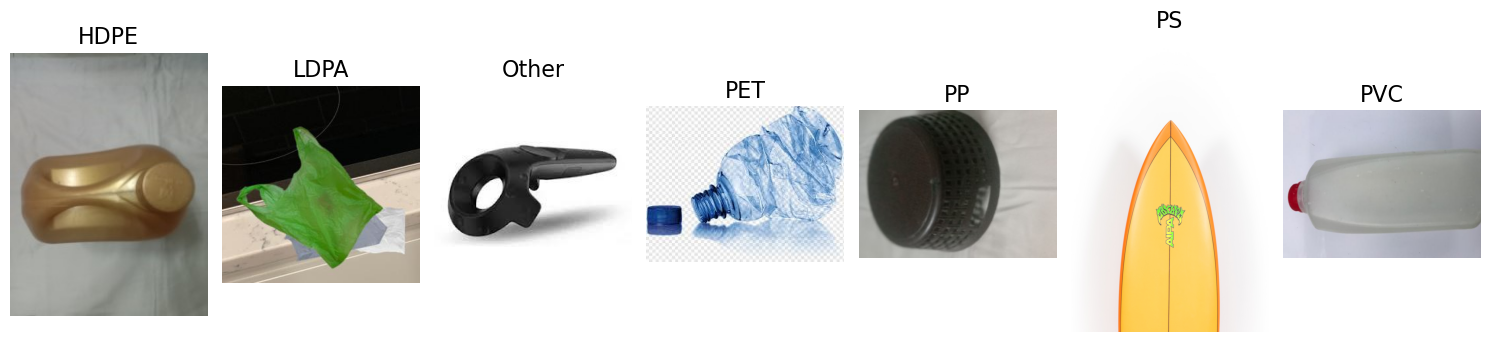

In [14]:
# Caminho das subpastas (cada uma é uma classe)
base_dir = '../data/Plastic_Classification/train/'
classes = os.listdir(base_dir)

# Mostrar 1 imagem aleatória por classe
plt.figure(figsize=(15, 6))

for i, plastic_class in enumerate(classes):
    class_path = os.path.join(base_dir, plastic_class)
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(1, 7, i+1)
    plt.imshow(img)
    plt.title(plastic_class)
    plt.axis('off')

plt.tight_layout()
plt.show()

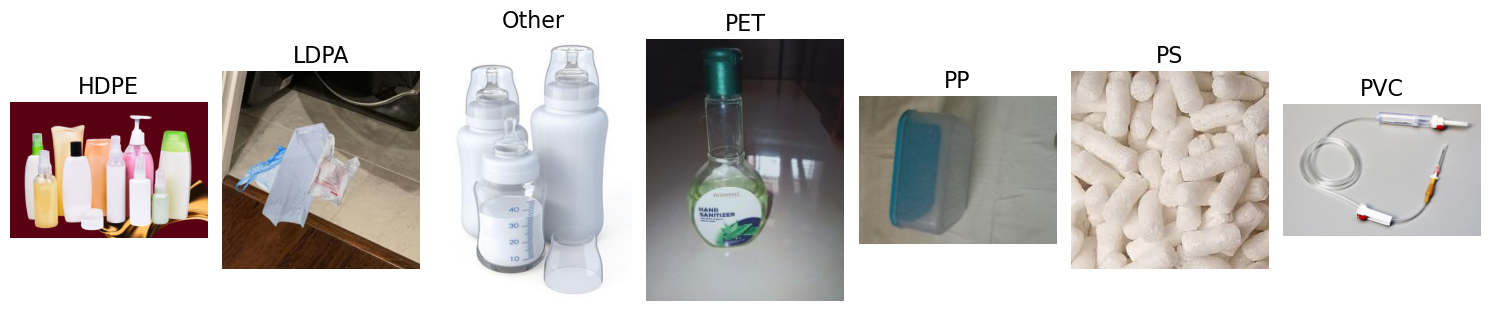

In [44]:
# Caminho das subpastas (cada uma é uma classe)
base_dir = '../data/Plastic_Classification/validation/'
classes = os.listdir(base_dir)

# Mostrar 1 imagem aleatória por classe
plt.figure(figsize=(15, 6))

for i, plastic_class in enumerate(classes):
    class_path = os.path.join(base_dir, plastic_class)
    img_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_file)

    img = mpimg.imread(img_path)
    plt.subplot(1, 7, i+1)
    plt.imshow(img)
    plt.title(plastic_class)
    plt.axis('off')

plt.tight_layout()
plt.show()

# 2 Pré-processamento

#### Etapas a ser seguida

- Renomear as imagens ok
- padronizar as extensões para .jpg ok
- verificar e corrigir o fromato real para jpeg ok
- remoção dos arquivos corrompidos, duplicados ou extensão indesejada (.avif, .webp) ok
- conversão de canais de cor para (3 canais)(RGB) ok
- 


## 2.1 Converter todas as imagens para .jpg


In [41]:
# caminho para o dataset
base_dir = "../data/Plastic_Classification/"

# As subpastas principais test train validation
subpastas = ["train", "test", "validation"]

# Extensões de imagem que queremos converter
extensoes_validas = (".png", ".jpeg", ".bmp", ".tiff", ".webp", ".jfif", "'.avif'")

for parte in subpastas:
    caminho_parte = os.path.join(base_dir, parte)

    # Verifica cada classe dentro da pasta
    for classe in os.listdir(caminho_parte):
        caminho_classe = os.path.join(caminho_parte, classe)

        if not os.path.isdir(caminho_classe):
            continue

        print(f"Processando classe: {classe} em {parte}")

        for nome_arquivo in os.listdir(caminho_classe):
            caminho_arquivo = os.path.join(caminho_classe, nome_arquivo)

            # Pular se já for .jpg
            if nome_arquivo.lower().endswith(".jpg"):
                continue

            # Verifica se é uma imagem a ser convertida
            if nome_arquivo.lower().endswith(extensoes_validas):
                try:
                    with Image.open(caminho_arquivo) as img:
                        # Corrige imagens com transparência ou paleta
                        if img.mode == "P":
                            img = img.convert("RGBA")
                        if img.mode in ["RGBA", "LA"]:
                            fundo = Image.new("RGB", img.size, (255, 255, 255))
                            fundo.paste(img, mask=img.split()[-1])  # usa canal alfa
                            img = fundo
                        elif img.mode != "RGB":
                            img = img.convert("RGB")

                        # Nome do novo arquivo .jpg
                        nome_base = os.path.splitext(nome_arquivo)[0]
                        novo_nome = f"{nome_base}.jpg"
                        caminho_novo = os.path.join(caminho_classe, novo_nome)

                        # Salva e remove o original
                        img.save(caminho_novo, "JPEG", quality=90)
                        os.remove(caminho_arquivo)

                        print(f"✅ Convertido: {nome_arquivo} → {novo_nome}")

                except UnidentifiedImageError:
                    print(f"⚠️ Erro: imagem inválida - {caminho_arquivo}")
                except Exception as e:
                    print(f"❌ Erro ao processar {nome_arquivo}: {e}")

print("\n✅ Conversão finalizada. Todas as imagens agora estão em formato .jpg")

Processando classe: HDPE em train
Processando classe: LDPA em train
Processando classe: Other em train
Processando classe: PET em train
Processando classe: PP em train
Processando classe: PS em train
Processando classe: PVC em train
Processando classe: HDPE em test
Processando classe: LDPA em test
Processando classe: Other em test
Processando classe: PET em test
Processando classe: PP em test
Processando classe: PS em test
Processando classe: PVC em test
Processando classe: HDPE em validation
Processando classe: LDPA em validation
Processando classe: Other em validation
Processando classe: PET em validation
Processando classe: PP em validation
Processando classe: PS em validation
❌ Erro ao processar 5pcs-Sanrio-Kawaii-Hello-Kitty-Hanger-Cartoon-Cute-Seamless-Kids-Clothes-Hanger-Student-Dormitory-Ins-Anime-Clothes-Storage-Rack_07a1c36a-6a79-46c3-9e96-e547833b4db7.89cf.jpeg: [Errno 2] No such file or directory: '../data/Plastic_Classification/validation\\PS\\5pcs-Sanrio-Kawaii-Hello-Kitt

#### Removido manualmente a imagem do dataset com problema para converter para jpg


#### Atualizar o dataset

In [45]:
# criando um novo dataset
dataset = "../data/Plastic_Classification"

pastas = {
    "train": os.path.join(dataset, "train"),
    "test": os.path.join(dataset, "test"),
    "validation": os.path.join(dataset, "validation"),
}

# Lista onde vamos armazenar os dados
dados = []


# Função para obter as informações de cada imagem
def coletar_dados(pasta_base, nome_conjunto):
    classes = [
        c for c in os.listdir(pasta_base) if os.path.isdir(os.path.join(pasta_base, c))
    ]

    for classe in sorted(classes):
        caminho_classe = os.path.join(pasta_base, classe)

        for nome_arquivo in os.listdir(caminho_classe):
            if nome_arquivo.lower().endswith(
                (".jpg", ".jpeg", ".png", ".bmp", ".tiff", ".webp", "jfif", ".avif")
            ):
                caminho_imagem = os.path.join(caminho_classe, nome_arquivo)

                try:
                    with Image.open(caminho_imagem) as img:
                        largura, altura = img.size
                except:
                    largura, altura = None, None  # erro ao abrir a imagem

                _, extensao = os.path.splitext(nome_arquivo)

                dados.append(
                    {
                        "conjunto": nome_conjunto,
                        "classe": classe,
                        "arquivo": nome_arquivo,
                        "largura": largura,
                        "altura": altura,
                        "extensao": extensao.lower(),
                    }
                )


# Coleta os dados de cada pasta
for nome_conjunto, caminho in pastas.items():
    coletar_dados(caminho, nome_conjunto)

# Cria DataFrame
df = pd.DataFrame(dados)

# Visualiza as primeiras linhas
print(df.head())

# Salva em CSV
df.to_csv("imagens_detalhadas.csv", index=False)
print("\n📁 Arquivo 'imagens_detalhadas.csv' salvo com sucesso!")


C:\Users\graci.DESKTOP-I7T8UK6\AppData\Roaming\Python\Python311\site-packages\PIL\Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


  conjunto classe        arquivo  largura  altura extensao
0    train   HDPE    image_1.jpg   1280.0  1280.0     .jpg
1    train   HDPE   image_10.jpg   1280.0  1280.0     .jpg
2    train   HDPE  image_100.jpg    192.0   256.0     .jpg
3    train   HDPE  image_101.jpg    256.0   192.0     .jpg
4    train   HDPE  image_102.jpg    256.0   192.0     .jpg

📁 Arquivo 'imagens_detalhadas.csv' salvo com sucesso!


In [47]:
df.head()

,conjunto,classe,arquivo,largura,altura,extensao
0,train,HDPE,image_1.jpg,1280.0,1280.0,.jpg
1,train,HDPE,image_10.jpg,1280.0,1280.0,.jpg
2,train,HDPE,image_100.jpg,192.0,256.0,.jpg
3,train,HDPE,image_101.jpg,256.0,192.0,.jpg
4,train,HDPE,image_102.jpg,256.0,192.0,.jpg


In [46]:
df["extensao"].unique()

array(['.jpg', '.avif'], dtype=object)

In [49]:
df[df['extensao']=='.avif']

,conjunto,classe,arquivo,largura,altura,extensao
1386,train,PVC,image_40.avif,NaN,NaN,.avif


In [50]:
## removido a imagem manualmente e removido do dataset
# Remove as linhas onde a extensão é '.avif'
df = df[df['extensao'] != '.avif']

In [51]:
# verificar as extensoes
print(df['extensao'].unique())

['.jpg']


### 2.2 Verificar imagens duplicadas

In [52]:
# Caminho da pasta raiz
base_dir = "../data/Plastic_Classification"

# Armazenar hashes
hash_dict = defaultdict(list)

# Subpastas
pastas = ["train", "test", "validation"]

for parte in pastas:
    caminho_parte = os.path.join(base_dir, parte)

    for classe in os.listdir(caminho_parte):
        caminho_classe = os.path.join(caminho_parte, classe)
        if not os.path.isdir(caminho_classe):
            continue

        for nome_arquivo in os.listdir(caminho_classe):
            caminho_img = os.path.join(caminho_classe, nome_arquivo)
            if not nome_arquivo.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            try:
                with Image.open(caminho_img) as img:
                    img_hash = imagehash.phash(img)
                    hash_dict[str(img_hash)].append(caminho_img)
            except Exception as e:
                print(f"⚠️ Erro ao processar {caminho_img}: {e}")

# Filtrar duplicatas (hash com mais de uma imagem)
duplicatas = {k: v for k, v in hash_dict.items() if len(v) > 1}

# Mostrar duplicatas encontradas
print(f"\n🔎 Encontradas {len(duplicatas)} duplicatas perceptuais:\n")
for hash_val, arquivos in duplicatas.items():
    print(f"🔗 Hash {hash_val} ({len(arquivos)} imagens):")
    for arq in arquivos:
        print(f"  └── {arq}")


⚠️ Erro ao processar ../data/Plastic_Classification\train\PS\Medmount-Medical-Lab-Disposable-Graduated-30ml-40ml-60ml-100ml-Universal-Plastic-PP-PS-Sterile-Urine-Stool-Specimen-Sample-Collection-Cup-Container-with-Label.jpg: [Errno 2] No such file or directory: '../data/Plastic_Classification\\train\\PS\\Medmount-Medical-Lab-Disposable-Graduated-30ml-40ml-60ml-100ml-Universal-Plastic-PP-PS-Sterile-Urine-Stool-Specimen-Sample-Collection-Cup-Container-with-Label.jpg'

🔎 Encontradas 26 duplicatas perceptuais:

🔗 Hash c7ec3a93e54e9218 (2 imagens):
  └── ../data/Plastic_Classification\train\HDPE\image_13.jpg
  └── ../data/Plastic_Classification\validation\HDPE\image_48.jpg
🔗 Hash b986864bc279f174 (2 imagens):
  └── ../data/Plastic_Classification\train\HDPE\image_21.jpg
  └── ../data/Plastic_Classification\validation\HDPE\image_47.jpg
🔗 Hash e8c6951f6ec4892b (2 imagens):
  └── ../data/Plastic_Classification\train\Other\image_100.jpg
  └── ../data/Plastic_Classification\validation\Other\image

## 2.2.1 Remover as imagens duplicadas que esteja na mesma subpasta e mesma classe

In [53]:
# eliminar as duplicadas
# Caminho base
base_dir = "../data/Plastic_Classification"
pastas = ["train", "test", "validation"]

# Percorrer cada subpasta
for parte in pastas:
    caminho_parte = os.path.join(base_dir, parte)

    for classe in os.listdir(caminho_parte):
        caminho_classe = os.path.join(caminho_parte, classe)

        if not os.path.isdir(caminho_classe):
            continue

        print(f"\n📂 Verificando duplicatas em: {parte}/{classe}")

        hash_para_arquivos = defaultdict(list)

        for nome_arquivo in os.listdir(caminho_classe):
            caminho_img = os.path.join(caminho_classe, nome_arquivo)

            if not nome_arquivo.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            try:
                with Image.open(caminho_img) as img:
                    img_hash = imagehash.phash(img)
                    hash_para_arquivos[str(img_hash)].append(caminho_img)
            except Exception as e:
                print(f"⚠️ Erro ao processar {caminho_img}: {e}")

        # Remover duplicatas (somente dentro da mesma pasta)
        duplicatas_local = {k: v for k, v in hash_para_arquivos.items() if len(v) > 1}

        total_removidas = 0

        for hash_val, arquivos in duplicatas_local.items():
            # Mantém o primeiro arquivo e remove os outros
            for arquivo in arquivos[1:]:
                try:
                    os.remove(arquivo)
                    print(f"🗑️ Removido (duplicata): {arquivo}")
                    total_removidas += 1
                except Exception as e:
                    print(f"❌ Erro ao remover {arquivo}: {e}")

        print(f"✅ {total_removidas} duplicatas removidas em: {parte}/{classe}")


📂 Verificando duplicatas em: train/HDPE
✅ 0 duplicatas removidas em: train/HDPE

📂 Verificando duplicatas em: train/LDPA
✅ 0 duplicatas removidas em: train/LDPA

📂 Verificando duplicatas em: train/Other
✅ 0 duplicatas removidas em: train/Other

📂 Verificando duplicatas em: train/PET
✅ 0 duplicatas removidas em: train/PET

📂 Verificando duplicatas em: train/PP
✅ 0 duplicatas removidas em: train/PP

📂 Verificando duplicatas em: train/PS
⚠️ Erro ao processar ../data/Plastic_Classification\train\PS\Medmount-Medical-Lab-Disposable-Graduated-30ml-40ml-60ml-100ml-Universal-Plastic-PP-PS-Sterile-Urine-Stool-Specimen-Sample-Collection-Cup-Container-with-Label.jpg: [Errno 2] No such file or directory: '../data/Plastic_Classification\\train\\PS\\Medmount-Medical-Lab-Disposable-Graduated-30ml-40ml-60ml-100ml-Universal-Plastic-PP-PS-Sterile-Urine-Stool-Specimen-Sample-Collection-Cup-Container-with-Label.jpg'
✅ 0 duplicatas removidas em: train/PS

📂 Verificando duplicatas em: train/PVC
✅ 0 duplicat

remover a imagem que estava duplicada e que deu erro para ser encontrada

## 2.3 Verificar número de canais em todas as imagens

Esse script percorre todas as imagens em train, test, validation e mostra:

- Caminho da imagem

- Modo (RGB, L, RGBA, etc.)

- Quantidade de canais (1, 3, 4...)

    "1": 1,      # Preto e branco 1-bit (pixels são 0 ou 1)
    "L": 1,      # Escala de cinza 8-bit (valores de 0 a 255)
    "P": 1,      # Paleta (cores indexadas, normalmente convertidas para RGB ou RGBA)
    "RGB": 3,    # Vermelho, Verde, Azul → padrão para imagens coloridas
    "RGBA": 4,   # RGB + Alpha (transparência)
    "CMYK": 4,   # Ciano, Magenta, Amarelo, Preto → usado para impressão
    "LA": 2,     # Luminosidade (escala de cinza) + Alpha
    "HSV": 3     # Matiz, Saturação, Valor (espaço de cor alternativo ao RGB)

In [54]:
# Caminho base
base_dir = "../data/Plastic_Classification"
pastas = ["train", "test", "validation"]

# Mapear modos para número de canais
modo_para_canais = {
    "1": 1,      # Preto e branco 1-bit (pixels são 0 ou 1)
    "L": 1,      # Escala de cinza 8-bit (valores de 0 a 255)
    "P": 1,      # Paleta (cores indexadas, normalmente convertidas para RGB ou RGBA)
    "RGB": 3,    # Vermelho, Verde, Azul → padrão para imagens coloridas
    "RGBA": 4,   # RGB + Alpha (transparência)
    "CMYK": 4,   # Ciano, Magenta, Amarelo, Preto → usado para impressão
    "LA": 2,     # Luminosidade (escala de cinza) + Alpha
    "HSV": 3     # Matiz, Saturação, Valor (espaço de cor alternativo ao RGB)
}

# Armazenar resultados
estatisticas = {}

for parte in pastas:
    caminho_parte = os.path.join(base_dir, parte)

    for classe in os.listdir(caminho_parte):
        caminho_classe = os.path.join(caminho_parte, classe)
        if not os.path.isdir(caminho_classe):
            continue

        for nome_arquivo in os.listdir(caminho_classe):
            caminho_img = os.path.join(caminho_classe, nome_arquivo)
            if not nome_arquivo.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            try:
                with Image.open(caminho_img) as img:
                    modo = img.mode
                    canais = modo_para_canais.get(modo, "desconhecido")

                    chave = (modo, canais)
                    estatisticas[chave] = estatisticas.get(chave, 0) + 1

            except Exception as e:
                print(f"⚠️ Erro ao processar {caminho_img}: {e}")

# Mostrar resultados
print("\n📊 Distribuição de canais nas imagens:")
for (modo, canais), quantidade in estatisticas.items():
    print(f"🖼️ Modo: {modo} | Canais: {canais} → {quantidade} imagens")


📊 Distribuição de canais nas imagens:
🖼️ Modo: RGB | Canais: 3 → 2066 imagens


### padronizar as imagens para rgb(3 canais)

| Modo   | Ação recomendada                                       |
| ------ | ------------------------------------------------------ |
| `L`    | Converter para `RGB` com `convert('RGB')`              |
| `RGBA` | Remover canal alfa (ex: fundo branco)                  |
| `P`    | Converter para `RGBA` ou `RGB` (como já fizemos antes) |


## 2.4 Padronizar TODAS as imagens para RGB (3 canais)

In [55]:
# Caminho base do dataset
base_dir = "../data/Plastic_Classification"
pastas = ["train", "test", "validation"]

# Contadores
total_convertidas = 0
erros = []

for parte in pastas:
    caminho_parte = os.path.join(base_dir, parte)

    for classe in os.listdir(caminho_parte):
        caminho_classe = os.path.join(caminho_parte, classe)

        if not os.path.isdir(caminho_classe):
            continue

        for nome_arquivo in os.listdir(caminho_classe):
            caminho_img = os.path.join(caminho_classe, nome_arquivo)

            if not nome_arquivo.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            try:
                with Image.open(caminho_img) as img:
                    if img.mode != "RGB":
                        print(f"🔁 Convertendo: {caminho_img} (modo: {img.mode})")

                        # Se tiver transparência (RGBA), aplicamos fundo branco
                        if img.mode in ["RGBA", "LA"]:
                            fundo = Image.new("RGB", img.size, (255, 255, 255))
                            fundo.paste(
                                img, mask=img.split()[-1]
                            )  # usa canal alfa como máscara
                            img = fundo
                        else:
                            img = img.convert("RGB")

                        # Salva sobrescrevendo
                        img.save(caminho_img)
                        total_convertidas += 1

            except Exception as e:
                erros.append((caminho_img, str(e)))
                print(f"⚠️ Erro ao processar {caminho_img}: {e}")

# ✅ Resultado final
print(f"\n✅ Conversão finalizada: {total_convertidas} imagens convertidas para RGB.")
if erros:
    print(f"⚠️ {len(erros)} imagens apresentaram erro. Deseja salvar em um log?")


✅ Conversão finalizada: 0 imagens convertidas para RGB.


#### Atualização do dataframe com novas informação do dataset

In [56]:
# Base do dataset
base_dir = "../data/Plastic_Classification"
pastas = ["train", "test", "validation"]

# Lista para armazenar os dados
dados_imagens = []

for parte in pastas:
    pasta_base = os.path.join(base_dir, parte)

    for classe in os.listdir(pasta_base):
        pasta_classe = os.path.join(pasta_base, classe)
        if not os.path.isdir(pasta_classe):
            continue

        for nome_arquivo in os.listdir(pasta_classe):
            caminho_img = os.path.join(pasta_classe, nome_arquivo)

            if not nome_arquivo.lower().endswith((".jpg", ".jpeg", ".png")):
                continue

            try:
                with Image.open(caminho_img) as img:
                    hash_img = str(imagehash.phash(img))
                    formato = img.format if img.format else "unknown"
                    largura, altura = img.size
                    canais = len(img.getbands())

                    dados_imagens.append(
                        {
                            "img_path": caminho_img.replace("\\", "/"),
                            "hash": hash_img,
                            "format": formato,
                            "width": largura,
                            "height": altura,
                            "channels": canais,
                            "class": classe,
                        }
                    )

            except UnidentifiedImageError:
                print(f"⚠️ Imagem inválida: {caminho_img}")
            except Exception as e:
                print(f"❌ Erro ao processar {caminho_img}: {e}")

# Criar o DataFrame
df_imagens = pd.DataFrame(dados_imagens)

# Visualizar amostra
print(df_imagens.head())

# (Opcional) Salvar em CSV
df_imagens.to_csv("dados_imagens_plastic.csv", index=False)
print("\n✅ DataFrame criado e salvo como 'dados_imagens_plastic.csv'")

                                            img_path              hash format  \
0  ../data/Plastic_Classification/train/HDPE/imag...  e1ce1cc9182c7fb2   JPEG   
1  ../data/Plastic_Classification/train/HDPE/imag...  b3cfcd24cc30cc33   JPEG   
2  ../data/Plastic_Classification/train/HDPE/imag...  e6169b3331cc6678   JPEG   
3  ../data/Plastic_Classification/train/HDPE/imag...  be66d1916bc2943c   JPEG   
4  ../data/Plastic_Classification/train/HDPE/imag...  e14f8eb00cdb336c   JPEG   

   width  height  channels class  
0   1280    1280         3  HDPE  
1   1280    1280         3  HDPE  
2    192     256         3  HDPE  
3    256     192         3  HDPE  
4    256     192         3  HDPE  

✅ DataFrame criado e salvo como 'dados_imagens_plastic.csv'


In [64]:
df_imagens.head()

,img_path,hash,format,width,height,channels,class
0,../data/Plastic_Classification/train/HDPE/imag...,e1ce1cc9182c7fb2,JPEG,1280,1280,3,HDPE
1,../data/Plastic_Classification/train/HDPE/imag...,b3cfcd24cc30cc33,JPEG,1280,1280,3,HDPE
2,../data/Plastic_Classification/train/HDPE/imag...,e6169b3331cc6678,JPEG,192,256,3,HDPE
3,../data/Plastic_Classification/train/HDPE/imag...,be66d1916bc2943c,JPEG,256,192,3,HDPE
4,../data/Plastic_Classification/train/HDPE/imag...,e14f8eb00cdb336c,JPEG,256,192,3,HDPE


In [70]:
df_imagens['format'].value_counts()

format
JPEG    2028
WEBP      37
PNG        1
Name: count, dtype: int64

In [68]:
df_imagens['channels'].unique()

array([3], dtype=int64)

### 2.5 Forçar que imagens .jpg realmente estejam no formato JPEG


In [69]:
# Caminho base
base_dir = '../data/Plastic_Classification'
pastas = ['train', 'test', 'validation']

# Contador
convertidas = 0
total = 0

for parte in pastas:
    pasta_parte = os.path.join(base_dir, parte)

    for classe in os.listdir(pasta_parte):
        pasta_classe = os.path.join(pasta_parte, classe)
        if not os.path.isdir(pasta_classe):
            continue

        for nome_arquivo in os.listdir(pasta_classe):
            caminho_img = os.path.join(pasta_classe, nome_arquivo)

            if not nome_arquivo.lower().endswith('.jpg'):
                continue

            total += 1
            try:
                with Image.open(caminho_img) as img:
                    if img.format != 'JPEG':
                        print(f"🔁 Convertendo: {caminho_img} (formato real: {img.format})")
                        img = img.convert('RGB')
                        img.save(caminho_img, format='JPEG')
                        convertidas += 1

            except Exception as e:
                print(f"⚠️ Erro ao processar {caminho_img}: {e}")

print(f"\n✅ Finalizado: {convertidas} imagens regravadas como JPEG de {total} analisadas.")

🔁 Convertendo: ../data/Plastic_Classification\train\HDPE\image_11.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PET\image_204.jpg (formato real: PNG)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_157.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_163.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_164.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_166.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_167.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_180.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_185.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_199.jpg (formato real: WEBP)
🔁 Convertendo: ../data/Plastic_Classification\train\PVC\image_201.jpg (formato real: WEBP)


In [71]:
## novo dataFrame 

# Caminho base
base_dir = '../data/Plastic_Classification'
pastas = ['train', 'test', 'validation']

# Lista para os dados
dados = []

for parte in pastas:
    pasta_parte = os.path.join(base_dir, parte)

    for classe in os.listdir(pasta_parte):
        pasta_classe = os.path.join(pasta_parte, classe)
        if not os.path.isdir(pasta_classe):
            continue

        for nome_arquivo in os.listdir(pasta_classe):
            caminho_img = os.path.join(pasta_classe, nome_arquivo)

            # Ignora arquivos que não são imagens esperadas
            if not nome_arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.jfif', '.avif')):
                continue

            try:
                with Image.open(caminho_img) as img:
                    # Extração dos dados
                    hash_img = str(imagehash.phash(img))
                    formato = img.format or 'unknown'
                    largura, altura = img.size
                    canais = len(img.getbands())
                    extensao = os.path.splitext(nome_arquivo)[1].lower()

                    dados.append({
                        'img_path': caminho_img.replace('\\', '/'),
                        'hash': hash_img,
                        'format': formato,
                        'width': largura,
                        'height': altura,
                        'channels': canais,
                        'class': classe,
                        'extension': extensao
                    })

            except UnidentifiedImageError:
                print(f"⚠️ Imagem inválida: {caminho_img}")
            except Exception as e:
                print(f"❌ Erro ao processar {caminho_img}: {e}")

# Criar o DataFrame
df_novo = pd.DataFrame(dados)

# Visualizar amostra
print(df_novo.head())

# (Opcional) salvar em CSV
df_novo.to_csv('dados_imagens_atualizado.csv', index=False)
print("\n✅ DataFrame salvo como 'dados_imagens_atualizado.csv'")


                                            img_path              hash format  \
0  ../data/Plastic_Classification/train/HDPE/imag...  e1ce1cc9182c7fb2   JPEG   
1  ../data/Plastic_Classification/train/HDPE/imag...  b3cfcd24cc30cc33   JPEG   
2  ../data/Plastic_Classification/train/HDPE/imag...  e6169b3331cc6678   JPEG   
3  ../data/Plastic_Classification/train/HDPE/imag...  be66d1916bc2943c   JPEG   
4  ../data/Plastic_Classification/train/HDPE/imag...  e14f8eb00cdb336c   JPEG   

   width  height  channels class extension  
0   1280    1280         3  HDPE      .jpg  
1   1280    1280         3  HDPE      .jpg  
2    192     256         3  HDPE      .jpg  
3    256     192         3  HDPE      .jpg  
4    256     192         3  HDPE      .jpg  

✅ DataFrame salvo como 'dados_imagens_atualizado.csv'


In [72]:
df_novo.head()

,img_path,hash,format,width,height,channels,class,extension
0,../data/Plastic_Classification/train/HDPE/imag...,e1ce1cc9182c7fb2,JPEG,1280,1280,3,HDPE,.jpg
1,../data/Plastic_Classification/train/HDPE/imag...,b3cfcd24cc30cc33,JPEG,1280,1280,3,HDPE,.jpg
2,../data/Plastic_Classification/train/HDPE/imag...,e6169b3331cc6678,JPEG,192,256,3,HDPE,.jpg
3,../data/Plastic_Classification/train/HDPE/imag...,be66d1916bc2943c,JPEG,256,192,3,HDPE,.jpg
4,../data/Plastic_Classification/train/HDPE/imag...,e14f8eb00cdb336c,JPEG,256,192,3,HDPE,.jpg


In [73]:
df_novo['format'].unique()

array(['JPEG'], dtype=object)

In [74]:
df_novo['extension'].unique()

array(['.jpg'], dtype=object)

In [75]:
df_novo['channels'].unique()

array([3], dtype=int64)

## 2.6 Redimensionar as imagens das pastas test, train e validation para 224x224

In [76]:
# Caminho original e novo
origem_base = '../data/Plastic_Classification'
destino_base = '../data/Plastic_Classification_224'

# # Tamanho desejado
tamanho = (224, 224)

# Cria a nova estrutura de pastas
if os.path.exists(destino_base):
    shutil.rmtree(destino_base)  # Remove se já existir para evitar duplicidade
    
os.makedirs(destino_base, exist_ok=True)

# Subpastas: train, test, validation
subpastas = ['train', 'validation', 'test']
total = 0
convertidas = 0

for parte in subpastas:
    pasta_origem = os.path.join(origem_base, parte)
    pasta_destino = os.path.join(destino_base, parte)
    os.makedirs(pasta_destino, exist_ok=True)

    for classe in os.listdir(pasta_origem):
        caminho_classe_origem = os.path.join(pasta_origem, classe)
        caminho_classe_destino = os.path.join(pasta_destino, classe)
        os.makedirs(caminho_classe_destino, exist_ok=True)

        for arquivo in os.listdir(caminho_classe_origem):
            if not arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.jfif', '.avif')):
                continue

            origem = os.path.join(caminho_classe_origem, arquivo)
            destino = os.path.join(caminho_classe_destino, os.path.splitext(arquivo)[0] + '.jpg')
            total += 1

            try:
                with Image.open(origem) as img:
                    img = img.convert('RGB')       # Garante 3 canais
                    img = img.resize(tamanho)      # Redimensiona
                    img.save(destino, format='JPEG')  # Salva no novo caminho
                    convertidas += 1
            except Exception as e:
                print(f"⚠️ Erro ao processar {origem}: {e}")

print(f"\n✅ Redimensionamento completo: {convertidas}/{total} imagens salvas em 224x224 em '{destino_base}'")



✅ Redimensionamento completo: 2066/2066 imagens salvas em 224x224 em '../data/Plastic_Classification_224'


## 2.7 Redimensionar as imagens das pastas test, train e validation para 229x229

In [77]:
# Caminho original e novo
origem_base = '../data/Plastic_Classification'
destino_base = '../data/Plastic_Classification_299'

# Tamanho desejado
tamanho = (299, 299)

# Cria a nova estrutura de pastas
if os.path.exists(destino_base):
    shutil.rmtree(destino_base)  # Remove se já existir

os.makedirs(destino_base, exist_ok=True)

# Subpastas: train, test, validation
subpastas = ['train', 'validation', 'test']
total = 0
convertidas = 0

for parte in subpastas:
    pasta_origem = os.path.join(origem_base, parte)
    pasta_destino = os.path.join(destino_base, parte)
    os.makedirs(pasta_destino, exist_ok=True)

    for classe in os.listdir(pasta_origem):
        caminho_classe_origem = os.path.join(pasta_origem, classe)
        caminho_classe_destino = os.path.join(pasta_destino, classe)
        os.makedirs(caminho_classe_destino, exist_ok=True)

        for arquivo in os.listdir(caminho_classe_origem):
            if not arquivo.lower().endswith(('.jpg', '.jpeg', '.png', '.webp', '.jfif', '.avif')):
                continue

            origem = os.path.join(caminho_classe_origem, arquivo)
            destino = os.path.join(caminho_classe_destino, os.path.splitext(arquivo)[0] + '.jpg')
            total += 1

            try:
                with Image.open(origem) as img:
                    img = img.convert('RGB')       # Garante 3 canais
                    img = img.resize(tamanho)      # Redimensiona
                    img.save(destino, format='JPEG')  # Salva no novo caminho
                    convertidas += 1
            except Exception as e:
                print(f"⚠️ Erro ao processar {origem}: {e}")

print(f"\n✅ Redimensionamento completo: {convertidas}/{total} imagens salvas em 299x299 em '{destino_base}'")



✅ Redimensionamento completo: 2066/2066 imagens salvas em 299x299 em '../data/Plastic_Classification_299'


## 2.8 Normalização dos pixels

📌 Objetivo:
Transformar os valores dos pixels das imagens de uma escala [0, 255] para uma escala [0, 1] (ou outra, dependendo do modelo).

### Por que normalizar?
Ajudar o modelo a convergir mais rápido e com mais estabilidade

Evitar que valores muito altos causem gradientes explosivos

É obrigatório quando se trabalha com relu, sigmoid, softmax, etc.

In [78]:
# Keras / TensorFlow
datagen = ImageDataGenerator(
    rescale=1./255  # 🔍 Normaliza todos os pixels
)

train_gen = datagen.flow_from_directory(
    '../data/Plastic_Classification_224/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen.flow_from_directory(
    '../data/Plastic_Classification_224/validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen.flow_from_directory(
    '../data/Plastic_Classification_224/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 1441 images belonging to 7 classes.
Found 416 images belonging to 7 classes.
Found 209 images belonging to 7 classes.


## 2.9 Balanceamento das Classes em especial a classe PS

In [79]:
# Ver as classes desbalanceadas

base_dir = '../data/Plastic_Classification_224/train'
distribuicao = {}

for classe in os.listdir(base_dir):
    caminho_classe = os.path.join(base_dir, classe)
    if os.path.isdir(caminho_classe):
        qtd = len([f for f in os.listdir(caminho_classe) if f.endswith('.jpg')])
        distribuicao[classe] = qtd

for k, v in sorted(distribuicao.items(), key=lambda x: x[1], reverse=True):
    print(f"🧪 Classe '{k}': {v} imagens")


🧪 Classe 'HDPE': 209 imagens
🧪 Classe 'PP': 209 imagens
🧪 Classe 'LDPA': 208 imagens
🧪 Classe 'PS': 207 imagens
🧪 Classe 'PET': 205 imagens
🧪 Classe 'Other': 202 imagens
🧪 Classe 'PVC': 201 imagens


In [80]:
# Ver as classes desbalanceadas

base_dir = '../data/Plastic_Classification_224/test/'
distribuicao = {}

for classe in os.listdir(base_dir):
    caminho_classe = os.path.join(base_dir, classe)
    if os.path.isdir(caminho_classe):
        qtd = len([f for f in os.listdir(caminho_classe) if f.endswith('.jpg')])
        distribuicao[classe] = qtd

for k, v in sorted(distribuicao.items(), key=lambda x: x[1], reverse=True):
    print(f"🧪 Classe '{k}': {v} imagens")

🧪 Classe 'HDPE': 30 imagens
🧪 Classe 'LDPA': 30 imagens
🧪 Classe 'Other': 30 imagens
🧪 Classe 'PP': 30 imagens
🧪 Classe 'PS': 30 imagens
🧪 Classe 'PVC': 30 imagens
🧪 Classe 'PET': 29 imagens


In [81]:
# Ver as classes desbalanceadas

base_dir = '../data/Plastic_Classification_224/validation/'
distribuicao = {}

for classe in os.listdir(base_dir):
    caminho_classe = os.path.join(base_dir, classe)
    if os.path.isdir(caminho_classe):
        qtd = len([f for f in os.listdir(caminho_classe) if f.endswith('.jpg')])
        distribuicao[classe] = qtd

for k, v in sorted(distribuicao.items(), key=lambda x: x[1], reverse=True):
    print(f"🧪 Classe '{k}': {v} imagens")

🧪 Classe 'LDPA': 60 imagens
🧪 Classe 'Other': 60 imagens
🧪 Classe 'PP': 60 imagens
🧪 Classe 'PVC': 60 imagens
🧪 Classe 'PET': 59 imagens
🧪 Classe 'PS': 59 imagens
🧪 Classe 'HDPE': 58 imagens


não realizado o balanceamento das classe 

In [83]:

# Diretório base
base_dir = '../data/Plastic_Classification_224'

# Estrutura dos dados
data = []

# Verifica cada conjunto
for conjunto in ['train', 'validation', 'test']:
    pasta_conjunto = os.path.join(base_dir, conjunto)
    
    for classe in os.listdir(pasta_conjunto):
        pasta_classe = os.path.join(pasta_conjunto, classe)
        if os.path.isdir(pasta_classe):
            total_imagens = len([f for f in os.listdir(pasta_classe) if f.lower().endswith('.jpg')])
            data.append([conjunto, classe, total_imagens])

# DataFrame
df = pd.DataFrame(data, columns=['conjunto', 'classe', 'qtd_imagens'])

# Tabela resumida
tabela = df.pivot(index='classe', columns='conjunto', values='qtd_imagens').fillna(0).astype(int)

print(tabela)


conjunto  test  train  validation
classe                           
HDPE        30    209          58
LDPA        30    208          60
Other       30    202          60
PET         29    205          59
PP          30    209          60
PS          30    207          59
PVC         30    201          60


In [84]:
print(df.groupby('conjunto')['qtd_imagens'].sum())


conjunto
test           209
train         1441
validation     416
Name: qtd_imagens, dtype: int64
